In [1]:
library(readr)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ dplyr   0.8.4
✔ tibble  2.1.3     ✔ stringr 1.4.0
✔ tidyr   1.0.2     ✔ forcats 0.4.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
otu_data = read_tsv("../data/ecam-table-taxa.tsv", skip = 1)
otu_id = otu_data$`feature-id`
otu_data = data.frame(otu_data[, -1], check.names = FALSE)
rownames(otu_data) = otu_id

Parsed with column specification:
cols(
  .default = col_double(),
  `feature-id` = col_character()
)

See spec(...) for full column specifications.



In [3]:
meta_data = read_tsv("../data/ecam-sample-metadata.tsv")[-1, ]
meta_data = meta_data%>%rename(Sample.ID = `#SampleID`)

Parsed with column specification:
cols(
  `#SampleID` = col_character(),
  antiexposedall = col_character(),
  day_of_life = col_character(),
  delivery = col_character(),
  diet = col_character(),
  diet_3 = col_character(),
  mom_child = col_character(),
  month = col_character(),
  month_of_life = col_character(),
  sample_summary = col_character(),
  sex = col_character(),
  studyid = col_character()
)



In [4]:
source("../scripts/ancom_v2.1.R")

 Package ‘exactRankTests’ is no longer under development.
 Please consider using package ‘coin’ instead.



Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: tensorA


Attaching package: ‘tensorA’


The following object is masked from ‘package:base’:

    norm


Loading required package: robustbase

Loading required package: bayesm

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, scale, scale.default




In [5]:
# Step 1: Data preprocessing

feature_table = otu_data; sample_var = "Sample.ID"; group_var = "delivery"
out_cut = 0.05; zero_cut = 0.90; lib_cut = 0; neg_lb = TRUE
prepro = feature_table_pre_process(feature_table, meta_data, sample_var, group_var, 
                                   out_cut, zero_cut, lib_cut, neg_lb)
feature_table = prepro$feature_table # Preprocessed feature table
meta_data = prepro$meta_data # Preprocessed metadata
struc_zero = prepro$structure_zeros # Structural zero info

In [6]:
# Step 2: ANCOM

main_var = "delivery"; p_adj_method = "BH"; alpha = 0.05
adj_formula = NULL; rand_formula = "~ 1 | studyid"
t_start = Sys.time()
res = ANCOM(feature_table, meta_data, struc_zero, main_var, p_adj_method, 
            alpha, adj_formula, rand_formula)
t_end = Sys.time()
t_run = t_end - t_start # around 30s

write_csv(res$out, "outputs/res_ecam.csv")

In [7]:
# Step 3: Volcano Plot

# Number of taxa except structural zeros
n_taxa = ifelse(is.null(struc_zero), nrow(feature_table), sum(apply(struc_zero, 1, sum) == 0))
# Cutoff values for declaring differentially abundant taxa
cut_off = c(0.9 * (n_taxa -1), 0.8 * (n_taxa -1), 0.7 * (n_taxa -1), 0.6 * (n_taxa -1))
names(cut_off) = c("detected_0.9", "detected_0.8", "detected_0.7", "detected_0.6")

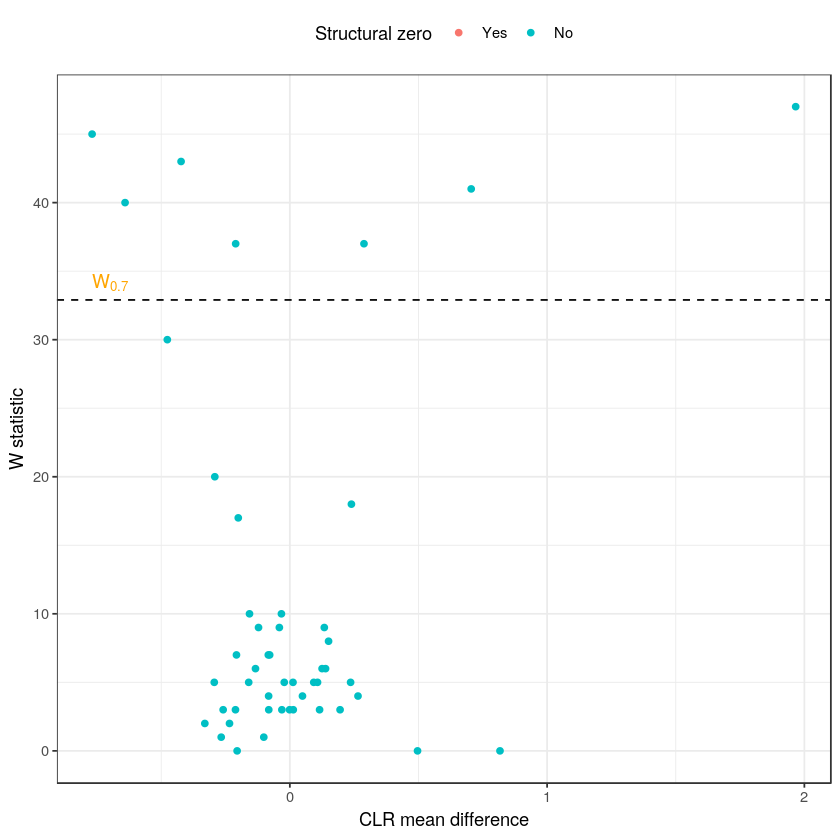

In [8]:
# Annotation data
dat_ann = data.frame(x = min(res$fig$data$x), y = cut_off["detected_0.7"], label = "W[0.7]")

fig = res$fig + 
  geom_hline(yintercept = cut_off["detected_0.7"], linetype = "dashed") + 
  geom_text(data = dat_ann, aes(x = x, y = y, label = label), 
            size = 4, vjust = -0.5, hjust = 0, color = "orange", parse = TRUE)
fig
ggsave("images/ecam.jpeg", height=5, width=6.25, units='in', dpi = 300)